In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Problem constants
c = torch.tensor([-9.54, -8.16, -4.26, -11.43], dtype=torch.float32)
A = torch.tensor([3.18, 2.72, 1.42, 3.81], dtype=torch.float32)
b = 7.81

# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(1, 100)  # First layer
        self.activation = nn.Tanh()     # Activation function
        self.layer2 = nn.Linear(100, 5) # Second layer

    def forward(self, t):
        hidden = self.activation(self.layer1(t))  # Pass through first layer
        output = self.layer2(hidden)              # Pass through second layer
        return output

# Training the neural network
def train_neural_network():
    # Initialize the neural network
    model = NeuralNetwork()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Very small learning rate
    loss_fn = nn.MSELoss()

    # Training parameters
    max_iters = 5000
    step_size = 0.01
    t = torch.tensor([[0.0]], dtype=torch.float32)  # Input to the neural network
    y = torch.zeros(5, dtype=torch.float32)  # Initial values [x1, x2, x3, x4, u]
    losses = []  # To store loss values

    for iteration in range(max_iters):
        optimizer.zero_grad()

        # Predict dy/dt using the neural network
        predicted_dy_dt = model(t)

        # Separate primal (x1, x2, x3, x4) and dual (u) variables
        x = y[:4]
        u = y[4]

        # Calculate the constraint residual
        g = torch.dot(A, x) - b

        # Define true dynamics
        dx_dt = c + A * torch.clamp(u + g, min=0)
        du_dt = torch.clamp(u + g, min=0) - u
        true_dy_dt = torch.cat([dx_dt, du_dt.unsqueeze(0)])

        # Compute the loss
        loss = loss_fn(predicted_dy_dt, true_dy_dt)
        losses.append(loss.item())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update y using Euler's method
        y = y + step_size * true_dy_dt.detach()
        y = torch.clamp(y, min=0)  # Ensure non-negativity

    # Plot the loss
    plt.plot(losses, label="Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Iterations vs Loss")
    plt.grid()
    plt.show()

# Run the training process
train_neural_network()

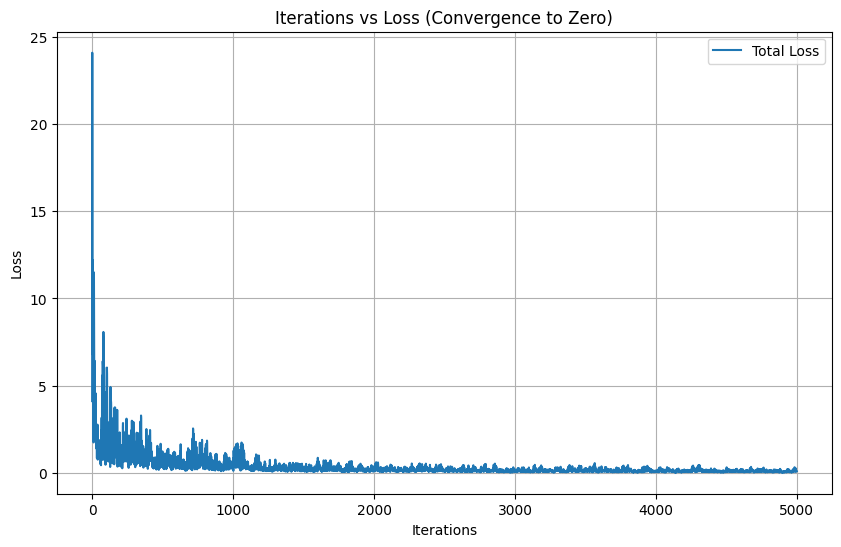

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define constants
b = 1.0  # Parameter b
u, n, w = 0.5, 0.3, 0.7  # Auxiliary variables

# Define the loss function (objective function of LP)
def loss_function(x1, x2, x3, x4):
    # Objective function: minimize -9.54*x1 + 16*x2 - 4.26*x3 - 11.43*x4
    return (-9.54 * x1 + 16 * x2 - 4.26 * x3 - 11.43 * x4)

# Neural network model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(1, 100),  # First layer: input size 1, output size 100
            nn.Tanh()           # Activation function: tanh
        )
        self.layer2 = nn.Linear(100, 5)  # Second layer: input size 100, output size 5

    def forward(self, x):
        x = self.layer1(x)
        return self.layer2(x)

# Initialize the neural network
model = NeuralNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
max_iterations = 5000
losses = []
x_init = torch.tensor([[0.0]])  # Initial input to the network (1-dimensional input)

for iteration in range(max_iterations):
    # Forward pass
    x_pred = model(x_init)  # Predict variables x1, x2, x3, x4, auxiliary

    # Extract variables
    x1, x2, x3, x4, aux = x_pred[0]

    # Compute residuals for constraints
    res = u + 3.18 * x1 + 2.72 * x2 + 1.42 * x3 + 3.81 * x4 - b
    res2 = n + 3.18 * x1 + 2.72 * x3 + 1.42 * x1 + 3.81 * x4 - b
    res3 = w - 3.18 * x1 + 2.72 * x1 + 1.42 * x1 + 3.81 * x4 - b

    # Total loss: objective function + penalties for constraints
    objective_loss = loss_function(x1, x2, x3, x4)
    constraint_loss = torch.abs(res) + torch.abs(res2) + torch.abs(res3)
    total_loss = constraint_loss + torch.abs(objective_loss)
    losses.append(total_loss.item())

    # Backward pass
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(max_iterations), losses, label='Total Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Iterations vs Loss (Convergence to Zero)')
plt.legend()
plt.grid()
plt.show()